In [0]:
import networkx as nx
import random
import scipy.stats 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stat
import urllib
%matplotlib inline
import pydot
import collections

# Exercise 1

Implement the following models in the language of your preference:

• Random graph.

• Watts-Strogatz model.

• Barabasi-Albert model.

Set the number of nodes to N = 2000, simulate the models for various
settings of the parameters and save the graphs. You may use graph data
structures provided by the existing network libraries or your own class to
store the graphs. For each graph:

• Report the number of vertices and edges.

• Compute the average degree and the variance of the degree distribution.

• Generate the frequency plot for the degrees of the nodes.

• Fit a model distribution to the obtained data. In case of the BarabasiAlbert graph, you may have a look at http://tuvalu.santafe.edu~aaronc/powerlaws/


For reporting the number of vertices and edges and for computing the average degree and the variance of the degree distribution i define function `stat(G)`

In [0]:
def stat(G):
    nodes = G.number_of_nodes()
    edges = G.number_of_edges()
    degrees = list(dict(G.degree()).values())
    mean_degree = np.mean(degrees)
    degree_variance = np.var(degrees)
    return {'nodes': nodes, 'edges': edges, 'mean': mean_degree, 'var': degree_variance}

Becouse I want generate the frequency plot for the degrees of the nodes.
I implement function `frequency_plot(G, mean,var)`. To fit a model distribution to the obtained data I use normal pdf function.



In [0]:
def frequency_plot(G,mean = None,var=None):
  degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
  degreeCount = collections.Counter(degree_sequence)
  deg, cnt = zip(*degreeCount.items())
  cnt = tuple(c/(len(degree_sequence)) for c in cnt)
  plt.bar(deg, cnt, width=0.80, color='b')

  plt.title("Degree Histogram")
  plt.ylabel("Count")
  plt.xlabel("Degree")

  if mean !=None:
    x = np.linspace(0, mean*2, 1000)
    y = scipy.stats.norm.pdf(x, mean, np.sqrt(var))
    plt.plot(x, y, 'r-')

  plt.show()
  return (deg,cnt)

## Random graph


I use a definition from lecture notes to implement function `random_graph`.

In [0]:
def random_graph(N, p):
    G = nx.Graph()
    G.add_nodes_from(range(N))
    for u in range(N):
        for v in range(u):
            if random.random() < p:
                G.add_edge(u, v)
    return G

Simulation:

In [0]:
R = random_graph(2000, 0.01)

Save to dot file.

In [0]:
nx.nx_pydot.write_dot(R, "R.dot")

In [0]:
from google.colab import files

files.download('R.dot')

I use `stat(G)` to calculate some statistics about graph.

In [0]:
s_R = stat(R)

I generate degree histogram with theoretical normal pdf.

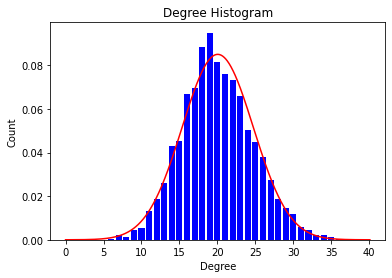

In [9]:
R_freq = frequency_plot(R,s_R['mean'], s_R['var'])

## Watz Strogatz model

I use definion from the lecture to implement function `watts_strogatz(N,K,beta)`.

In [0]:
def watts_strogatz(N, K, beta):
    G = nx.Graph()
    G.add_nodes_from(range(N))
    for u in range(N):
        for v in range(K//2):
            G.add_edge(u, (u+1+v)%N)
    for i in range(N):
        for j in G[i]:
            if i >= j:
                continue
            if random.random() < beta:
                G.remove_edge(i, j)
                k = i
                while k == i or k in G[i]:
                    k = random.randrange(N)
                G.add_edge(i, k)
    return G

And I do the same steps like in previous model.

In [0]:
WS = watts_strogatz(2000, 20, 0.5)

In [0]:
nx.nx_pydot.write_dot(WS, "WS.dot")

In [0]:
from google.colab import files

files.download('WS.dot')

In [0]:
s_WS = stat(WS)

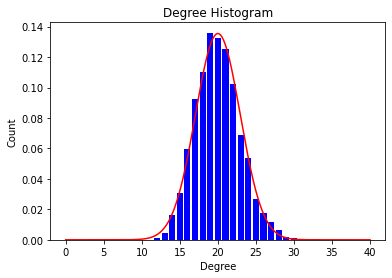

In [15]:
WS_freq = frequency_plot(WS,s_WS['mean'], s_WS['var'])

# Barabasi Albert model

I use a definition from lecture notes to define `barabasi_albert(N, m0, m)`.

In [0]:
def barabasi_albert(N, m0, m):
    G = nx.Graph()
    G.add_nodes_from(range(N))
    degrees = [0]*N
    for u in range(m0):
        degrees[u] = m0-1
        for v in range(u):
            G.add_edge(u, v)
    for j in range(m0, N):
        degrees[j] = m
        for something in range(m):
            i = random.choices(range(j), degrees[:j])[0]
            while i in G[j]:
                i = random.choices(range(j), degrees[:j])[0]
            G.add_edge(i, j)
            degrees[i] += 1
    return G

Next - simulation and statistics.

In [0]:
BA = barabasi_albert(2000, 25, 10)

In [0]:
nx.nx_pydot.write_dot(BA, "BA.dot")

In [0]:
from google.colab import files

files.download('BA.dot')

In [0]:
s_BA = stat(BA)

In case of the BarabasiAlbert graph, I look at http://tuvalu.santafe.edu/~aaronc/powerlaws/ but this sit doesn't exist, I find some informations in other pages and fit distribution of this model as below.
I plot the log-log scale chart and I notice that the linear regression maybe will work. But the fitting wasn't great... maybe I should cut some observations? But any of my idea don't work well...

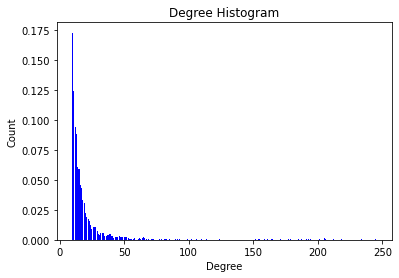

Text(0.5, 1.0, 'Log-log scale histogram')

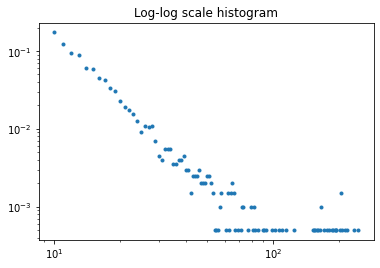

In [21]:
x,y = frequency_plot(BA)
plt.loglog(x,y, '.')
plt.title("Log-log scale histogram")

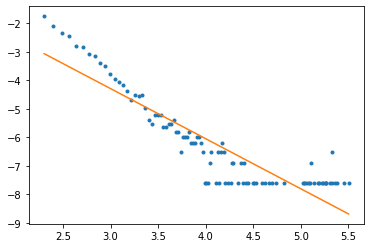

In [22]:
log_x=np.log(x)
log_y=np.log(y)
plt.plot(log_x,log_y,'.')
result = scipy.stats.linregress(np.log(x), np.log(y))
Y = np.exp(result.intercept)*x**result.slope
plt.plot(np.log(x),np.log(Y))


# Exercise 2

LiveJournal (www.livejournal.com) is a blogging site very popular in
Russia and Eastern Europe. It has a simple API and a generous policyfor data mining (see http://www.livejournal.com/bots/).

• Write a function that fetches a list of friends of a test user valerois
and transforms it into a graph.

• Once you have the list of friends, you may use the snowball sampling method (also known as chain sampling or respondent-driven
sampling) to map the social network:


```
Start with a central node
Obtain friends of the central node
For every friend:
Obtain friends of the friend
For every friend−of−friend
Obtain friends of friend−of−friend
Etc ...
```


Limit the depth of the search to two or three levels to avoid an
explosion of data.

• Save the results into a file. From know on work with the local copy
of the network instead of sampling it every time.

• Determine the number of nodes and edges in the network.

• Find celebrities in the network (hint: degree centrality).

• Plot the degree distribution of the network.

• Find communication bottlenecks (hint: betweenness centrality).

You are allowed to use network libraries to analyze the network.

I implement function `add_user(G, name)`.

In [0]:
def add_user(G, name):
    data = urllib.request.urlopen("http://www.livejournal.com/misc/fdata.bml?user="+name).readlines()
    for line in data:
        line = line.decode("utf-8")
        if not line.startswith('> ') and not line.startswith('< '):
            continue
        outgoing = line.startswith('> ')
        user = line[2:-1]
        if outgoing:
            G.add_edge(name, user)
        else:
            G.add_edge(user, name)

Now I create graph Journal and add "friends" of the user valerois using function `add_user(Journal,'valerois')`.

In [24]:
Journal = nx.DiGraph()
add_user(Journal, "valerois")
Journal.nodes()
Journal.edges()


OutEdgeView([('valerois', 'bagira'), ('valerois', 'angerona'), ('valerois', 'yankel'), ('valerois', 'yelya'), ('valerois', 'ponka'), ('valerois', 'marinka'), ('valerois', 'saper'), ('valerois', 'levinius'), ('valerois', 'monella'), ('valerois', 'irbisa'), ('valerois', 'innaplanetyanka'), ('valerois', 'hutshepsut'), ('valerois', 'skyg74'), ('valerois', 'samoleg'), ('valerois', 'actr'), ('valerois', 'gottfrid'), ('valerois', 'krimsky'), ('valerois', 'nelis'), ('valerois', 'ptfenix'), ('valerois', 'leprechaun'), ('valerois', 'a_u'), ('valerois', 'e_f'), ('valerois', 'boctok'), ('valerois', 'karial'), ('valerois', 'wattson'), ('valerois', 'baryshnia'), ('valerois', 'ntl'), ('valerois', 'salamandrina_'), ('valerois', 'ant_fugue'), ('valerois', 'levik'), ('valerois', '_milashka'), ('valerois', 'oonabond'), ('valerois', 'alinaf'), ('valerois', 'vollalol'), ('valerois', 'kitobow'), ('valerois', 'petitmari'), ('valerois', 'babushonok'), ('valerois', 'koniglio'), ('valerois', 'berryl'), ('valero

And I go deeper.

In [25]:
known_users = {'valerois'}
for new_user in list(Journal.nodes()):
    if new_user not in known_users and len(known_users)<10:     #only to show that this code works - shuld be:  
        known_users.add(new_user)
        print("Adding", new_user)   #only to show that this code works
        add_user(Journal, new_user)
"""for new_user in Journal.nodes():
    if new_user not in known_users:
        known_users.add(new_user)
        add_user(Journal, new_user)
for new_user in Journal.nodes():
    if new_user not in known_users:
        known_users.add(new_user)
        add_user(Journal, new_user)"""

Adding bagira
Adding angerona
Adding yankel
Adding yelya
Adding ponka
Adding marinka
Adding saper
Adding levinius
Adding monella


'for new_user in Journal.nodes():\n    if new_user not in known_users:\n        known_users.add(new_user)\n        add_user(Journal, new_user)\nfor new_user in Journal.nodes():\n    if new_user not in known_users:\n        known_users.add(new_user)\n        add_user(Journal, new_user)'

I save the graph to the dot file.

In [0]:
nx.nx_pydot.write_dot(Journal, "Journal.dot")

I use Google Colab and now I use file from my Google Drive in which I have save my graph (loading data from this site lasted a long time - I did it ony one time).

In [27]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
Journal_f = nx.nx_pydot.read_dot('/content/drive/My Drive/Colab Notebooks/Journal.dot')

Next steps like previous:

In [0]:
stat_J=stat(Journal_f)


In [0]:
x,y = frequency_plot(Journal_f)
plt.loglog(x,y, '.')
plt.title("Log-log scale histogram")

I find celebrities in the network.

In [0]:
deg_cent = nx.centrality.degree_centrality(Journal_f)

List of 20 first celebrities.

In [0]:
sorted(deg_cent.items(), key=lambda x: -x[1])[:20]

I find communication bottlenecks.

In [0]:
bet_cent = nx.centrality.betweenness_centrality(Journal_f, k=100)

List of first 20 person which are communication bottlenecks.

In [0]:
sorted(bet_cent.items(), key=lambda x: -x[1])[:20]